


### #0 导入nemo工具库及asr工具类

In [1]:
import nemo
import nemo.collections.asr as nemo_asr

[NeMo W 2022-11-21 10:29:52 optimizers:47] Apex was not found. Using the lamb optimizer will error out.
[NeMo W 2022-11-21 10:29:54 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text_dali._AudioTextDALIDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
nemo.__version__

'1.4.0'

In [ ]:
# nemo_asr.models.EncDecCTCModel.list_available_models()

In [ ]:
# asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_zh_quartznet15x5")
# asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_zh_citrinet_512")

### #1.1 加载自动语音识别模型


In [ ]:
# quartznet = nemo_asr.models.EncDecCTCModel.restore_from("stt_zh_quartznet15x5.nemo")# 加载中文预训练模型并实例化
citrinet = nemo_asr.models.EncDecCTCModel.restore_from("stt_zh_citrinet_512.nemo")# 加载中文预训练模型并实例化

### #1.2 传入音频文件 — 进行语音识别

In [ ]:
# asr_result = quartznet.transcribe(paths2audio_files=["/root/testdata/hi6.wav"]) # 调用transcribe函数测试预训练模型识别效果
# print(asr_result)

### #1.3 使用ASR_mertrics工具库对预训练模型识别结果计算准确率

In [3]:
from ASR_metrics import utils as metrics
# s1 = "你好大白请让我进入小区"#指定正确答案
# s2 = " ".join(asr_result)#识别结果
# print("字错率:{}".format(metrics.calculate_cer(s1,s2)))#计算字错率cer
# print("准确率:{}".format(1-metrics.calculate_cer(s1,s2)))#计算准确率accuracy

### #2 采集数据制作数据集

#### #2.1 录制语音文件：
######  录制语音文件，文件类型需统一转换为wav格式，采样率建议在44100HZ 、单声道。
######  通过录音软件Audacity录制：Ubuntu系统安装=>sudo apt install audacity 
###### windows系统可用此网址下载安装：https://www.onlinedown.net/soft/46359.htm
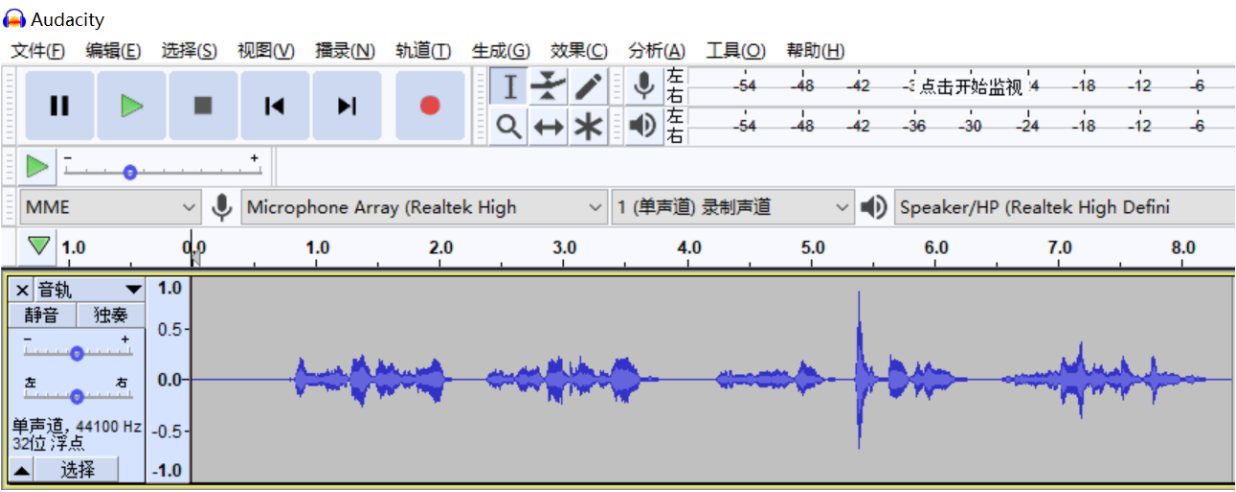

####  #2.2 制作数据清单格式要求：


In [ ]:
# 导入librosa音频工具包获取音频时长,用于制作语音数据集
# import librosa 
# time = librosa.get_duration(filename="/root/testdata/hi6.wav")
# print(time)

#### #2.3 加载数据清单

In [ ]:
# ! cat "./Hackathon_6th_ZZY/train.json"

In [6]:
 #将制作好的json格式的数据清单加载进来
train_manifest = "./Hackathon_6th_ZZY/train.json"
test_manifest = "./Hackathon_6th_ZZY/val.json"

#### #2.4 加载quartznet配置文件

In [4]:
# 使用YAML读取quartznet模型配置文件
# from ruamel_yaml import YAML 
import yaml
config_path = "./citrinet_512_zh.yaml"

# yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f, Loader = yaml.FullLoader)
print(params)

{'name': 'Citrinet-512', 'model': {'sample_rate': 16000, 'repeat': 5, 'dropout': 0.0, 'separable': True, 'labels': [' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '㶧', '䶮', '一', '丁', '七', '万', '丈', '三', '上', '下', '不', '与', '丐', '丑', '专', '且', '丕', '世', '丘', '丙', '业', '丛', '东', '丝', '丞', '丢', '两', '严', '丧', '个', '丫', '中', '丰', '串', '临', '丸', '丹', '为', '主', '丽', '举', '乃', '久', '么', '义', '之', '乌', '乍', '乎', '乏', '乐', '乒', '乓', '乔', '乖', '乘', '乙', '九', '乞', '也', '习', '乡', '书', '买', '乱', '乳', '乾', '了', '予', '争', '事', '二', '于', '亏', '云', '互', '五', '井', '亘', '亚', '些', '亟', '亡', '亢', '交', '亥', '亦', '产', '亨', '亩', '享', '京', '亭', '亮', '亲', '亳', '亵', '人', '亿', '什', '仁', '仄', '仅', '仆', '仇', '今', '介', '仍', '从', '仑', '仓', '仔', '仕', '他', '仗', '付', '仙', '仞', '仟', '仡', '代', '令', '以', '仨', '仪', '们', '仰', '仲', '件', '价', '任', '份', '仿', '企', '伉', '伊', '伍', '伎', '伏', '伐', '休', '众', '优', '伙', '会', '伞', '伟', '传', '伢',

#### #2.5 将数据清单传给配置文件

In [7]:
params['model']['train_ds']['manifest_filepath']=train_manifest
params['model']['validation_ds']['manifest_filepath']=test_manifest

### #3 训练模型
#### #3.1 使用迁移学习的方法训练模型

In [ ]:
citrinet.setup_training_data(train_data_config=params['model']['train_ds'])# 指向我们将用于微调的数据作为训练集
citrinet.setup_validation_data(val_data_config=params['model']['validation_ds'])# 指向新的验证数据进行微调
import pytorch_lightning as pl 
trainer = pl.Trainer(gpus=1,max_epochs=300)#重新设置训练器参数
trainer.fit(citrinet)#调用‘fit’方法开始训练 

#### #3.2 检验迁移学习训练模型的识别结果

In [ ]:
# print(citrinet.transcribe(paths2audio_files=["/root/testdata/hi6.wav"]))

#### 3.3模型的保存

In [ ]:
# citrinet.save_to("asr_model_sayhi2.nemo")# 将训练好的模型保存为.nemo格式

#### 3.4将训练好的模型进行重载

In [3]:
try_model_1 = nemo_asr.models.EncDecCTCModel.restore_from("7th_Hackathon_citrinet.nemo")#对模型进行重新加载

[NeMo W 2022-11-21 10:30:16 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: ./dataset/train.json
    sample_rate: 16000
    labels:
    - ' '
    - ''''
    - A
    - B
    - C
    - D
    - E
    - F
    - G
    - H
    - I
    - J
    - K
    - L
    - M
    - 'N'
    - O
    - P
    - Q
    - R
    - S
    - T
    - U
    - V
    - W
    - X
    - 'Y'
    - Z
    - 㶧
    - 䶮
    - 一
    - 丁
    - 七
    - 万
    - 丈
    - 三
    - 上
    - 下
    - 不
    - 与
    - 丐
    - 丑
    - 专
    - 且
    - 丕
    - 世
    - 丘
    - 丙
    - 业
    - 丛
    - 东
    - 丝
    - 丞
    - 丢
    - 两
    - 严
    - 丧
    - 个
    - 丫
    - 中
    - 丰
    - 串
    - 临
    - 丸
    - 丹
    - 为
    - 主
    - 丽
    - 举
    - 乃
    - 久
    - 么
    - 义
    - 之
    - 乌
    - 乍
    - 乎
    - 乏
    - 乐
    - 乒
    - 乓
    - 乔
    - 乖
    - 乘
    - 乙
  

[NeMo I 2022-11-21 10:30:16 features:262] PADDING: 16
[NeMo I 2022-11-21 10:30:16 features:279] STFT using torch


[NeMo W 2022-11-21 10:30:16 nemo_logging:349] /root/NeMo/nemo/collections/asr/parts/preprocessing/features.py:312: FutureWarning: Pass sr=16000, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
      librosa.filters.mel(sample_rate, self.n_fft, n_mels=nfilt, fmin=lowfreq, fmax=highfreq), dtype=torch.float
    


[NeMo I 2022-11-21 10:30:24 save_restore_connector:143] Model EncDecCTCModel was successfully restored from /root/train_nemo/ASR/7th_Hackathon_citrinet.nemo.


In [6]:
! pwd

/root/train_nemo/ASR


In [6]:
from glob import glob
from ASR_metrics import utils as metrics

# root = ""
true_result = {"guopi_pingzi": "请检测出果皮和瓶子",
                "guopi": "请检测出果皮",
                "pingzi": "请检测出瓶子",
                "zhixiang": "请检测出纸箱",
                "zhixiang_guopi": "请检测出纸箱和果皮",
                "zhixiang_guopi_pingzi": "请检测出纸箱果皮和瓶子",
                "zhixiang_pingzi": "请检测出纸箱和瓶子"}

# result_file = open("./result.txt", "a+")

for key, value in true_result.items():
    for filepath in glob("./dataset/train/{}/*.wav".format(key)):
#     for filepath in glob("./dataset/test/{}/*.wav".format(key)):
        model_result = try_model_1.transcribe(paths2audio_files=[filepath])
        CER = metrics.calculate_cer(value, " ".join(model_result))
        if CER != 0:
            print(filepath)
            print("Model result: {}, CER: {}".format(model_result, CER))
#             result_file.write(str("filename: {}, Model result: {}, CER: {} \n".format(filepath, model_result, CER)))
print("Finish!!")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

./dataset/train/guopi_pingzi/39.wav
Model result: ['检测出果皮和瓶子'], CER: 0.1111111111111111


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

./dataset/train/guopi_pingzi/60.wav
Model result: ['检测出果皮和瓶子'], CER: 0.1111111111111111


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

./dataset/train/guopi/101.wav
Model result: ['请检测出纸箱'], CER: 0.3333333333333333


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

./dataset/train/guopi/120.wav
Model result: ['检测出果皮'], CER: 0.16666666666666666


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

./dataset/train/guopi/126.wav
Model result: ['检测出果皮'], CER: 0.16666666666666666


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

./dataset/train/guopi/83.wav
Model result: ['请检测出'], CER: 0.3333333333333333


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

./dataset/train/zhixiang/67.wav
Model result: ['请检测出'], CER: 0.3333333333333333


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

./dataset/train/zhixiang/69.wav
Model result: ['请检测出'], CER: 0.3333333333333333


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Finish!!


In [13]:
asr_result = try_model_1.transcribe(paths2audio_files=["./Hackathon_6th_ZZY/train/ZZY1.wav"])

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-06-05 20:59:52 nemo_logging:349] /root/NeMo/nemo/collections/asr/parts/preprocessing/segment.py:75: FutureWarning: Pass orig_sr=44100, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
      samples = librosa.core.resample(samples, sample_rate, target_sr)
    


#### 3.5 对自定义模型识别结果计算准确率

In [14]:
from ASR_metrics import utils as metrics
s1 = "你好大白我是赵泽宇请让我进入小区"#指定正确答案
s2 = " ".join(asr_result)#识别结果
print("字错率:{}".format(metrics.calculate_cer(s1,s2)))#计算字错率cer
print("准确率:{}".format(1-metrics.calculate_cer(s1,s2)))#计算准确率accuracy

字错率:0.0
准确率:1.0


###  #4 成功拿到用于图像识别的语音指令
#### => 就可以作为输入给计算机视觉模型作为口罩检测二维码识别的指令 
#### 我们保存好经过验证的识别模型，为后续将模型移植部署在边缘计算备Jetson Nano中做准备